### Dataset

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder \
    .appName("Spark SQL app")\
    .getOrCreate()

25/03/20 15:27:09 WARN Utils: Your hostname, p4stwi2x resolves to a loopback address: 127.0.1.1; using 192.168.100.188 instead (on interface wlp2s0)
25/03/20 15:27:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/20 15:27:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path = "dataset/full/anime-dataset-2023.csv"

df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(path)

# element: UNKNOWN
df = df.replace({'UNKNOWN': None, 'Unknown': None})
df.dropDuplicates()

# change column names for better SQL
df = df.withColumnsRenamed({'Scored By': 'Scored_By'})

print(df.count())
df.show(20)

25/03/20 15:27:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


24905
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|                Name|        English name|                    Other name|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------

In [3]:
# check sparsity for each column
from pyspark.sql.functions import col
from collections import OrderedDict

rows = df.count()
sparsity_score = [df.filter(col(Col).isNotNull()).count() / rows for Col in df.columns]

sparsity_list = OrderedDict()
for i in range(len(df.columns)):
    sparsity_list[df.columns[i]] = sparsity_score[i]
#spark.createDataFrame([d_list]).show()
sparsity_list.items()

odict_items([('anime_id', 1.0), ('Name', 1.0), ('English name', 0.4146958442079904), ('Other name', 0.9948604697851837), ('Score', 0.6300742822726361), ('Genres', 0.8020879341497691), ('Synopsis', 1.0), ('Type', 0.9970287090945593), ('Episodes', 0.9754667737402128), ('Aired', 1.0), ('Premiered', 0.2210801043967075), ('Status', 1.0), ('Producers', 0.463963059626581), ('Licensors', 0.1901224653683999), ('Studios', 0.5773539449909657), ('Source', 0.851877133105802), ('Duration', 0.9733788395904437), ('Rating', 0.9731379241116241), ('Rank', 0.8148163019474001), ('Popularity', 1.0), ('Favorites', 1.0), ('Scored_By', 0.6300742822726361), ('Members', 1.0), ('Image URL', 1.0)])

### Data cleaning

#### Related functions

##### One-hot encoding

In [17]:
# cre: https://stackoverflow.com/questions/62408093/one-hot-encoding-multiple-categorical-data-in-a-column
import gc
def oneHotEncoding(dataFrame, colName: str, show: bool = True, support: int = 3):
    size_before = dataFrame.count()

    dataFrame = dataFrame.na.fill({colName: 'NA'})
    test_df = dataFrame.select(colName)
    if show:
        print(f"Fill rate: {test_df.filter(col(colName).isNotNull()).count()}/{test_df.count()}")

    # collect list of unique genres
    L = test_df.select(colName).rdd.flatMap(lambda x: x).collect()
    valueSet = {}
    for i in L:
        temp = i.split(", ")
        for j in temp:
            if j != "NA":
                if j not in valueSet.keys():
                    valueSet.update({j: 0})
                else:
                    valueSet[j] += 1
    # support
    for i in valueSet.copy():
        if valueSet[i] < support:
            valueSet.pop(i, None)
    print(valueSet)

    # transfer unique values to panda DF to map the entries
    test_df_pd = test_df.dropDuplicates().toPandas()
    test_df_pd = test_df_pd.reindex(test_df_pd.columns.tolist() + list(valueSet), axis=1, fill_value=0)
    input_list = test_df_pd[colName].tolist()
    for i in range(len(input_list)):
        temp = input_list[i].split(", ")
        for j in temp:
            if j != "NA" and j in valueSet.keys():
                test_df_pd.at[i, j] = 1
    test_df = spark.createDataFrame(test_df_pd)
    if show:
        test_df.show()

    dataFrame = dataFrame.join(test_df, colName, "left").drop(colName) #hmmmm
    if show:
        dataFrame.show()
    # print(f"Size before: {size_before}")
    # print(f"Size after: {df.count()}")

    # clean up mem
    del [[test_df_pd]]
    gc.collect()

    return dataFrame


##### Normalization: min max

In [5]:
from pyspark.sql.functions import min, max
def min_max(dataFrame, colName_in: str, colName_out: str):
    main = dataFrame.select(colName_in)
    filtered = main.filter(colName_in + " is not NULL")
    sc = filtered.select(min(colName_in), max(colName_in)).collect()
    mi, ma = sc[0][0], sc[0][1]

    dataFrame = dataFrame.withColumn(colName_out, (col(colName_in)-mi)/(ma-mi))

    return dataFrame

##### Normalization: standard score

In [6]:
from pyspark.sql.functions import mean, stddev, col
def standard_score(dataFrame, colName_in: str, colName_out: str):
    main = dataFrame.select(colName_in)
    filtered = main.filter(colName_in + " is not NULL")
    sc = filtered.select(mean(colName_in), stddev(colName_in)).collect()
    m, std = sc[0][0], sc[0][1]

    dataFrame = dataFrame.withColumn(colName_out, (col(colName_in)-m)/std)

    return dataFrame

##### Plot

In [7]:
from pyspark.sql.functions import min, max
import pandas as pd

def plot(dataFrame, colName: str):
    gre_histogram = dataFrame.select(colName).filter(col(colName).cast("float").isNotNull())\
        .rdd.flatMap(lambda x: x)\
        .map(float)\
        .histogram(20)

    pd.DataFrame(
        list(zip(*gre_histogram)), 
        columns=['bin', 'frequency']
    ).set_index('bin').plot(kind='bar')

##### Others

In [8]:
def print_shape(dataFrame):
    print(dataFrame.count(), len(dataFrame.columns))

#### Ineffective features: Name, English name, Other name (finished)

Since the problem is about recommendation based on user's taste, it is expected that these features have nothing to do with our recommendation system.

In [34]:
df = df.drop("Name", "English name", "Other name")
df.show()

+--------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|
+--------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|       1| 8.75|Action, Award Win...|Crime is timeless...|   TV|    26.0|Apr 3, 1998 to Ap...|spring 1998| Fi

In [35]:
print_shape(df)

24905 21


#### Score (finished)

As this is a numerical column, we perform data normalization.

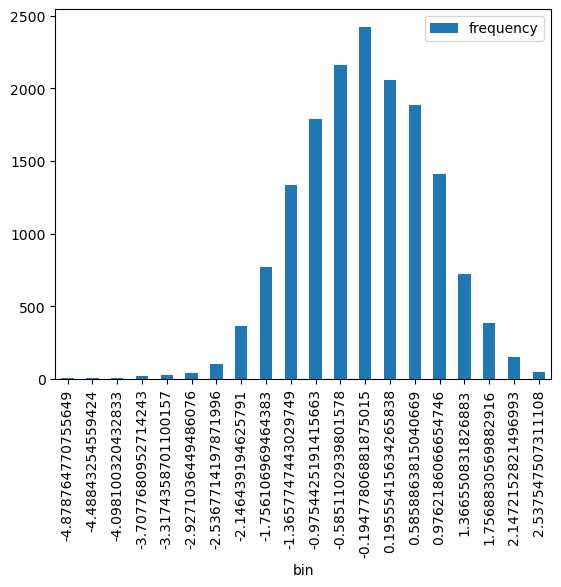

In [36]:
df = standard_score(df, "Score", "Score_s").drop("Score")

df = df.withColumnRenamed(existing="Score_s",new="Score")

plot(df, "Score")

In [37]:
from pyspark.sql.functions import median, mode
df.select(median("Score"), mode("Score")).show()

+--------------------+-----------------+
|       median(Score)|      mode(Score)|
+--------------------+-----------------+
|0.009809856093436304|0.171326638918847|
+--------------------+-----------------+



Even though the data is negatively skewed (mean = 0, median = 0.009, mode = 0.171), the skewed-ness is insignificant and can be allowed for analysis.

In [38]:
print_shape(df)

24905 21


#### Genres (finished)

Since the column is categorical and the label order in Genres is not important, we use one-hot encoding.

In [39]:
df = oneHotEncoding(df, "Genres")

Fill rate: 24905/24905


{'Action': 4729, 'Award Winning': 240, 'Sci-Fi': 3090, 'Adventure': 3841, 'Drama': 2835, 'Mystery': 846, 'Supernatural': 1493, 'Fantasy': 5305, 'Sports': 770, 'Comedy': 7141, 'Romance': 2062, 'Slice of Life': 1754, 'Suspense': 241, 'Ecchi': 794, 'Gourmet': 145, 'Avant Garde': 803, 'Horror': 533, 'Girls Love': 112, 'Boys Love': 168, 'Hentai': 1485, 'Erotica': 53}
+--------------------+------+-------------+------+---------+-----+-------+------------+-------+------+------+-------+-------------+--------+-----+-------+-----------+------+----------+---------+------+-------+
|              Genres|Action|Award Winning|Sci-Fi|Adventure|Drama|Mystery|Supernatural|Fantasy|Sports|Comedy|Romance|Slice of Life|Suspense|Ecchi|Gourmet|Avant Garde|Horror|Girls Love|Boys Love|Hentai|Erotica|
+--------------------+------+-------------+------+---------+-----+-------+------------+-------+------+------+-------+-------------+--------+-----+-------+-----------+------+----------+---------+------+-------+
|Come

+--------+--------------------+-------+--------+--------------------+-----------+---------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+--------------------+------+-------------+------+---------+-----+-------+------------+-------+------+------+-------+-------------+--------+-----+-------+-----------+------+----------+---------+------+-------+
|anime_id|            Synopsis|   Type|Episodes|               Aired|  Premiered|         Status|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|               Score|Action|Award Winning|Sci-Fi|Adventure|Drama|Mystery|Supernatural|Fantasy|Sports|Comedy|Romance|Slice of Life|Suspense|Ecchi|Gourmet|Avant Garde|Horror|Girls Love|Boys Love|Hentai|Erotica|
+--------+--------------------+-

In [40]:
print_shape(df)

24905 41


#### Synopsis (finished)

Synopsis is description of an anime title and has quite some impact to user's taste. However we temporarily leave this out for simplicity.

In [41]:
df = df.drop("Synopsis")

#### Type (finished)

Similar to Genres, we use one-hot encoding here.

In [44]:
df.select("Type").groupBy("Type").count().show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `Type` cannot be resolved. Did you mean one of the following? [`TV`, `ONA`, `OVA`, `Aired`, `Movie`].;
'Project ['Type]
+- Project [anime_id#2246, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score#3504, Action#3680L, Award Winning#3681L, Sci-Fi#3682L, Adventure#3683L, Drama#3684L, Mystery#3685L, ... 21 more fields]
   +- Project [Type#4300, anime_id#2246, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score#3504, Action#3680L, Award Winning#3681L, Sci-Fi#3682L, Adventure#3683L, Drama#3684L, ... 22 more fields]
      +- Join Inner, (Type#4300 = Type#4361)
         :- Project [anime_id#2246, coalesce(Type#2253, cast(NA as string)) AS Type#4300, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score#3504, Action#3680L, Award Winning#3681L, Sci-Fi#3682L, Adventure#3683L, Drama#3684L, ... 16 more fields]
         :  +- Project [anime_id#2246, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score#3504, Action#3680L, Award Winning#3681L, Sci-Fi#3682L, Adventure#3683L, Drama#3684L, ... 16 more fields]
         :     +- Project [anime_id#2246, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score#3504, Action#3680L, Award Winning#3681L, Sci-Fi#3682L, Adventure#3683L, ... 17 more fields]
         :        +- Project [Genres#3641, anime_id#2246, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score#3504, Action#3680L, Award Winning#3681L, Sci-Fi#3682L, ... 18 more fields]
         :           +- Join Inner, (Genres#3641 = Genres#3679)
         :              :- Project [anime_id#2246, coalesce(Genres#2251, cast(NA as string)) AS Genres#3641, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score#3504]
         :              :  +- Project [anime_id#2246, Genres#2251, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score_s#3460 AS Score#3504]
         :              :     +- Project [anime_id#2246, Genres#2251, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, Score_s#3460]
         :              :        +- Project [anime_id#2246, Score#2250, Genres#2251, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269, ((cast(Score#2250 as double) - 6.380889625286766) / 0.9286960610287833) AS Score_s#3460]
         :              :           +- Project [anime_id#2246, Score#2250, Genres#2251, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored_By#2295, Members#2268, Image URL#2269]
         :              :              +- Project [anime_id#2246, Name#2247, English name#2248, Other name#2249, Score#2250, Genres#2251, Synopsis#2252, Type#2253, Episodes#2254, Aired#2255, Premiered#2256, Status#2257, Producers#2258, Licensors#2259, Studios#2260, Source#2261, Duration#2262, Rating#2263, Rank#2264, Popularity#2265, Favorites#2266, Scored By#2267 AS Scored_By#2295, Members#2268, Image URL#2269]
         :              :                 +- Project [CASE WHEN (anime_id#2174 = Unknown) THEN cast(null as string) WHEN (anime_id#2174 = UNKNOWN) THEN cast(null as string) ELSE anime_id#2174 END AS anime_id#2246, CASE WHEN (Name#2175 = Unknown) THEN cast(null as string) WHEN (Name#2175 = UNKNOWN) THEN cast(null as string) ELSE Name#2175 END AS Name#2247, CASE WHEN (English name#2176 = Unknown) THEN cast(null as string) WHEN (English name#2176 = UNKNOWN) THEN cast(null as string) ELSE English name#2176 END AS English name#2248, CASE WHEN (Other name#2177 = Unknown) THEN cast(null as string) WHEN (Other name#2177 = UNKNOWN) THEN cast(null as string) ELSE Other name#2177 END AS Other name#2249, CASE WHEN (Score#2178 = Unknown) THEN cast(null as string) WHEN (Score#2178 = UNKNOWN) THEN cast(null as string) ELSE Score#2178 END AS Score#2250, CASE WHEN (Genres#2179 = Unknown) THEN cast(null as string) WHEN (Genres#2179 = UNKNOWN) THEN cast(null as string) ELSE Genres#2179 END AS Genres#2251, CASE WHEN (Synopsis#2180 = Unknown) THEN cast(null as string) WHEN (Synopsis#2180 = UNKNOWN) THEN cast(null as string) ELSE Synopsis#2180 END AS Synopsis#2252, CASE WHEN (Type#2181 = Unknown) THEN cast(null as string) WHEN (Type#2181 = UNKNOWN) THEN cast(null as string) ELSE Type#2181 END AS Type#2253, CASE WHEN (Episodes#2182 = Unknown) THEN cast(null as string) WHEN (Episodes#2182 = UNKNOWN) THEN cast(null as string) ELSE Episodes#2182 END AS Episodes#2254, CASE WHEN (Aired#2183 = Unknown) THEN cast(null as string) WHEN (Aired#2183 = UNKNOWN) THEN cast(null as string) ELSE Aired#2183 END AS Aired#2255, CASE WHEN (Premiered#2184 = Unknown) THEN cast(null as string) WHEN (Premiered#2184 = UNKNOWN) THEN cast(null as string) ELSE Premiered#2184 END AS Premiered#2256, CASE WHEN (Status#2185 = Unknown) THEN cast(null as string) WHEN (Status#2185 = UNKNOWN) THEN cast(null as string) ELSE Status#2185 END AS Status#2257, CASE WHEN (Producers#2186 = Unknown) THEN cast(null as string) WHEN (Producers#2186 = UNKNOWN) THEN cast(null as string) ELSE Producers#2186 END AS Producers#2258, CASE WHEN (Licensors#2187 = Unknown) THEN cast(null as string) WHEN (Licensors#2187 = UNKNOWN) THEN cast(null as string) ELSE Licensors#2187 END AS Licensors#2259, CASE WHEN (Studios#2188 = Unknown) THEN cast(null as string) WHEN (Studios#2188 = UNKNOWN) THEN cast(null as string) ELSE Studios#2188 END AS Studios#2260, CASE WHEN (Source#2189 = Unknown) THEN cast(null as string) WHEN (Source#2189 = UNKNOWN) THEN cast(null as string) ELSE Source#2189 END AS Source#2261, CASE WHEN (Duration#2190 = Unknown) THEN cast(null as string) WHEN (Duration#2190 = UNKNOWN) THEN cast(null as string) ELSE Duration#2190 END AS Duration#2262, CASE WHEN (Rating#2191 = Unknown) THEN cast(null as string) WHEN (Rating#2191 = UNKNOWN) THEN cast(null as string) ELSE Rating#2191 END AS Rating#2263, CASE WHEN (Rank#2192 = Unknown) THEN cast(null as string) WHEN (Rank#2192 = UNKNOWN) THEN cast(null as string) ELSE Rank#2192 END AS Rank#2264, CASE WHEN (Popularity#2193 = Unknown) THEN cast(null as string) WHEN (Popularity#2193 = UNKNOWN) THEN cast(null as string) ELSE Popularity#2193 END AS Popularity#2265, CASE WHEN (Favorites#2194 = Unknown) THEN cast(null as string) WHEN (Favorites#2194 = UNKNOWN) THEN cast(null as string) ELSE Favorites#2194 END AS Favorites#2266, CASE WHEN (Scored By#2195 = Unknown) THEN cast(null as string) WHEN (Scored By#2195 = UNKNOWN) THEN cast(null as string) ELSE Scored By#2195 END AS Scored By#2267, CASE WHEN (Members#2196 = Unknown) THEN cast(null as string) WHEN (Members#2196 = UNKNOWN) THEN cast(null as string) ELSE Members#2196 END AS Members#2268, CASE WHEN (Image URL#2197 = Unknown) THEN cast(null as string) WHEN (Image URL#2197 = UNKNOWN) THEN cast(null as string) ELSE Image URL#2197 END AS Image URL#2269]
         :              :                    +- Relation [anime_id#2174,Name#2175,English name#2176,Other name#2177,Score#2178,Genres#2179,Synopsis#2180,Type#2181,Episodes#2182,Aired#2183,Premiered#2184,Status#2185,Producers#2186,Licensors#2187,Studios#2188,Source#2189,Duration#2190,Rating#2191,Rank#2192,Popularity#2193,Favorites#2194,Scored By#2195,Members#2196,Image URL#2197] csv
         :              +- LogicalRDD [Genres#3679, Action#3680L, Award Winning#3681L, Sci-Fi#3682L, Adventure#3683L, Drama#3684L, Mystery#3685L, Supernatural#3686L, Fantasy#3687L, Sports#3688L, Comedy#3689L, Romance#3690L, Slice of Life#3691L, Suspense#3692L, Ecchi#3693L, Gourmet#3694L, Avant Garde#3695L, Horror#3696L, Girls Love#3697L, Boys Love#3698L, Hentai#3699L, Erotica#3700L], false
         +- LogicalRDD [Type#4361, TV#4362L, Special#4363L, OVA#4364L, ONA#4365L, Movie#4366L, Music#4367L], false


Since only 0.3% of samples have empty values, so we should have no problem dropping these rows.

In [35]:
df = df.filter("Type is not NULL")
df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Then we perform one-hot encoding

In [43]:
df = oneHotEncoding(df, "Type")

Fill rate: 24905/24905


{'TV': 7596, 'Special': 2557, 'OVA': 4075, 'ONA': 3532, 'Movie': 4380, 'Music': 2685}


+-------+---+-------+---+---+-----+-----+
|   Type| TV|Special|OVA|ONA|Movie|Music|
+-------+---+-------+---+---+-----+-----+
|     TV|  1|      0|  0|  0|    0|    0|
|     NA|  0|      0|  0|  0|    0|    0|
|Special|  0|      1|  0|  0|    0|    0|
|    OVA|  0|      0|  1|  0|    0|    0|
|  Music|  0|      0|  0|  0|    0|    1|
|  Movie|  0|      0|  0|  0|    1|    0|
|    ONA|  0|      0|  0|  1|    0|    0|
+-------+---+-------+---+---+-----+-----+



+--------+--------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+--------------------+------+-------------+------+---------+-----+-------+------------+-------+------+------+-------+-------------+--------+-----+-------+-----------+------+----------+---------+------+-------+---+-------+---+---+-----+-----+
|anime_id|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|               Score|Action|Award Winning|Sci-Fi|Adventure|Drama|Mystery|Supernatural|Fantasy|Sports|Comedy|Romance|Slice of Life|Suspense|Ecchi|Gourmet|Avant Garde|Horror|Girls Love|Boys Love|Hentai|Erotica| TV|Special|OVA|ONA|Movie|Music|
+--------+--------+-----

In [45]:
print_shape(df)

24905 45


#### Episodes

In [46]:
df = standard_score(df, "Episodes", "A1").withColumnRenamed("A1", "Episodes")

#### Aired (finished)

The format is in the form of "(start date) to (end date)", so we perform splitting into two columns.

In [47]:
# column: Aired 
from pyspark.sql.functions import split, to_date

split_col = split(df["Aired"], " to ", 2)
df = df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
df = df.withColumn("air_start", to_date(col("F1"), "MMM d, yyyy"))\
    .withColumn("air_end", to_date(col("F2"), "MMM d, yyyy"))\
    .drop("F1", "F2", "Aired")
df.select("air_start", "air_end").show()

+----------+-------+
| air_start|air_end|
+----------+-------+
|      NULL|   NULL|
|2005-09-14|   NULL|
|1989-03-11|   NULL|
|2023-07-03|   NULL|
|2008-11-29|   NULL|
|2022-10-14|   NULL|
|2022-12-30|   NULL|
|2021-07-09|   NULL|
|2022-08-19|   NULL|
|2022-06-11|   NULL|
|      NULL|   NULL|
|2021-07-02|   NULL|
|2021-10-30|   NULL|
|      NULL|   NULL|
|2020-10-01|   NULL|
|2020-02-01|   NULL|
|2019-08-23|   NULL|
|2019-08-09|   NULL|
|2022-02-04|   NULL|
|2019-02-15|   NULL|
+----------+-------+
only showing top 20 rows



In some cases, some titles do not have both timestamps.

In [48]:
print(df.select("air_start", "air_end").where("air_start is not NULL").count())
print(df.select("air_start", "air_end").where("air_end is not NULL").count())
print(df.select("air_start", "air_end").where("air_start is not NULL AND air_end is not NULL").count())
print(df.count())

20090


9337


9317


24905


Since the number of missing values is huge for both columns and users can manually filter the recommendation rankings, our choice is to drop the columns in processing.

In [49]:
df = df.drop("air_start", "air_end")
df.show()

+--------+--------+-----------+----------------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+--------------------+------+-------------+------+---------+-----+-------+------------+-------+------+------+-------+-------------+--------+-----+-------+-----------+------+----------+---------+------+-------+---+-------+---+---+-----+-----+--------------------+
|anime_id|Episodes|  Premiered|          Status|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|               Score|Action|Award Winning|Sci-Fi|Adventure|Drama|Mystery|Supernatural|Fantasy|Sports|Comedy|Romance|Slice of Life|Suspense|Ecchi|Gourmet|Avant Garde|Horror|Girls Love|Boys Love|Hentai|Erotica| TV|Special|OVA|ONA|Movie|Music|            Episodes|
+--------+--------+-----

#### Premiered (skewness not dealt)

Since some users might have the tendency to watch the latest titles, and so as some for the older titles for nostalgia, trendy eras, etc., we shall use this feature. The feature is in the form of season and year, which we shall transform into real numbers.

Column sparsity: 0.2210801043967075


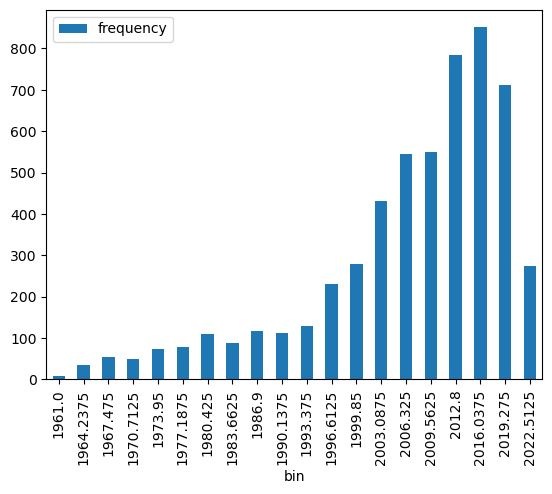

In [50]:
from pyspark.sql.functions import split, col

print(f"Column sparsity: {sparsity_list["Premiered"]}")

split_col = split(df["Premiered"], " ", 2)
df = df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
df = df.na.replace(['spring', 'summer', 'fall', 'winter'], ['0', '0.25', '0.5', '0.75'], 'F1')\
    .withColumn("Premiered_f", col('F1')+col('F2')).drop("Premiered", "F1", "F2")
plot(df, "Premiered_f")

Normalization to standard scores.

+--------------------+------------------+
|median(Premiered_fo)|mode(Premiered_fo)|
+--------------------+------------------+
|  0.2761786744566387|0.6619614031164164|
+--------------------+------------------+



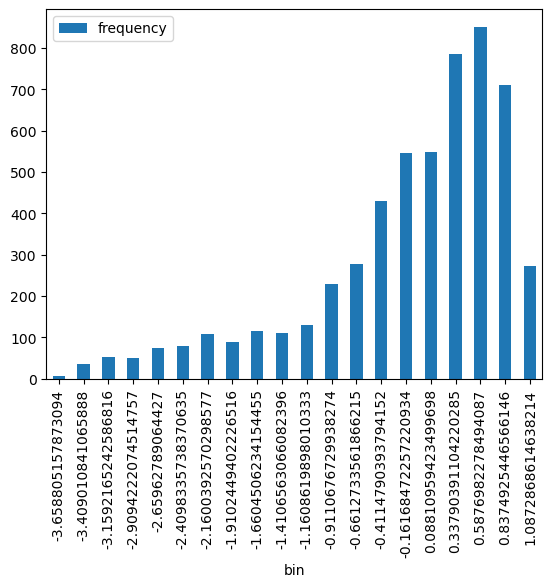

In [51]:
from pyspark.sql.functions import mean, median, mode
df = standard_score(df, "Premiered_f", "Premiered_fo")

df.select(median("Premiered_fo"), mode("Premiered_fo")).show()

df = df.drop("Premiered", "Premiered_f").withColumnRenamed(existing="Premiered_fo", new="Premiered")
plot(df, "Premiered")

#### Status, Producers, Licensors, Studios, Source

Similar to some Genres and Type, we shall one-hot encode these features.

In [ ]:
temp_df = df
print_shape(temp_df)
temp_df = oneHotEncoding(temp_df, "Producers", show=False, support=500)
print_shape(temp_df)
temp_df.show()

24905 24
{'TV Tokyo': 572, 'Aniplex': 579, 'NHK': 826}


In [42]:
df = oneHotEncoding(df, "Status", show=False)
df = oneHotEncoding(df, "Producers", show=False)
df = oneHotEncoding(df, "Licensors", show=False)
df = oneHotEncoding(df, "Studios", show=False)
df = oneHotEncoding(df, "Source", show=False)

df.show()

{'Finished Airing': 24062, 'Not yet aired': 420, 'Currently Airing': 346}


{'Studio Mausu': 88, 'Avex Pictures': 113, 'NHK': 826, 'Youku': 38, 'iQIYI': 50, 'bilibili': 191, 'Tencent Penguin Pictures': 175, 'Xuanshi Tangmen': 5, 'China Literature Limited': 36, 'Toei Animation': 22, 'Kamio Japan': 8, 'King Records': 98, 'Sunrise': 18, 'Shueisha': 305, 'Sanrio': 206, 'Shogakukan': 105, 'Yuewen Animation & Comics': 5, 'Sotsu': 319, 'Tatsunoko Production': 10, 'Happinet': 13, 'Bit grooove promotion': 43, 'Tencent Animation & Comics': 62, 'VAP': 160, 'Pie in the sky': 3, 'Fuji TV': 371, 'Kadokawa': 333, 'Notes': 34, 'INSPION Edge': 3, 'TV Tokyo': 572, 'Kodansha': 307, 'Movic': 397, 'Hakuhodo DY Media Partners': 39, 'Hakuhodo': 13, 'NBCUniversal Entertainment Japan': 92, 'Half H.P Studio': 125, 'Takara Tomy A.R.T.S': 5, 'Queen Bee': 42, 'Mediabank': 99, 'Gold Bear': 6, 'Pink Pineapple': 273, 'Showten': 16, 'Lune Pictures': 78, 'Mary Jane': 53, 'Mousou Jitsugen Media': 3, 'Sony Pictures Entertainment': 31, 'Dentsu': 369, 'BS Fuji': 81, 'Crunchyroll': 89, 'NetEase': 1

/tmp/ipykernel_57688/327834522.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_pd.at[i, j] = 1
/tmp/ipykernel_57688/327834522.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_pd.at[i, j] = 1
/tmp/ipykernel_57688/327834522.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  t

{'Funimation': 1210, '4Kids Entertainment': 42, 'Sentai Filmworks': 926, 'Aniplex of America': 238, 'Enoki Films': 11, 'Crunchyroll': 103, 'ADV Films': 304, 'GKIDS': 70, 'VIZ Media': 198, 'Discotek Media': 490, 'The Pokemon Company International': 43, 'NYAV Post': 66, 'Geneon Entertainment USA': 180, 'Central Park Media': 152, 'Eleven Arts': 18, 'Tokyopop': 13, 'Nelvana': 13, 'Shout! Factory': 7, 'Manga Entertainment': 63, 'Urban Vision': 21, 'Saban Entertainment': 37, 'Bandai Entertainment': 200, 'Maiden Japan': 66, 'AnimEigo': 38, 'Warner Bros. Pictures': 16, 'Disney Platform Distribution': 17, 'Saban Brands': 3, 'Anchor Bay Films': 3, 'Sony Pictures Entertainment': 10, 'Flatiron Film Company': 16, 'Bandai Visual USA': 19, 'Nozomi Entertainment': 141, 'NIS America': 54, 'Inc.': 54, 'Media Blasters': 287, 'Mill Creek Entertainment': 3, 'Streamline Pictures': 4, 'Ponycan USA': 27, 'Marvel Entertainment': 5, 'Dentsu Entertainment USA': 4, 'Miramax Films': 6, 'Kadokawa Pictures USA': 8, 

25/03/19 17:05:42 WARN TaskSetManager: Stage 654 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:05:51 WARN TaskSetManager: Stage 675 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:05:58 WARN TaskSetManager: Stage 699 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.


{'Toei Animation': 862, 'Studio Deen': 311, 'Kachidoki Studio': 61, 'Pollyanna Graphics': 4, 'OTOIRO': 14, 'Qzil.la': 4, 'LICO': 6, 'Pie in the sky': 17, 'Ruo Hong Culture': 41, 'Wonder Cat Animation': 7, 'Soyep': 27, 'Original Force': 7, 'Motion Magic': 13, 'B.CMAY PICTURES': 19, 'Foch Films': 27, 'Red Dog Culture House': 4, 'AQUA ARIS': 64, 'Sunrise Beyond': 9, 'Studio Hokiboshi': 10, 'LX Animation Studio': 3, 'Yostar Pictures': 13, 'Keyring': 5, 'Fenz': 13, 'Gathering': 42, 'Kate Arrow': 6, 'Sparkly Key Animation Studio': 29, 'J.C.Staff': 407, 'Super Normal Studio': 5, 'Wawayu Animation': 12, 'Hololive Production': 11, 'Studio PuYUKAI': 41, 'DLE': 195, 'Angle': 3, 'Lesprit': 17, 'Nomad': 36, 'Oddjob': 14, 'W-Toon Studio': 19, 'DMM.futureworks': 14, 'Colored Pencil Animation': 11, 'Signal.MD': 30, 'Studio Bind': 5, 'AIC': 190, 'Shaft': 140, 'Blue bread': 24, 'Anime Antenna Iinkai': 47, 'Studio 1st': 49, 'Rabbit Gate': 13, 'Nur': 11, 'T-Rex': 130, 'New Generation': 14, 'Majin': 14, 'S

25/03/19 17:06:05 WARN TaskSetManager: Stage 717 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.
/tmp/ipykernel_57688/327834522.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_pd.at[i, j] = 1
/tmp/ipykernel_57688/327834522.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_pd.at[i, j] = 1
/tmp/ipykernel_57688/327834522.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

{'Original': 9607, 'Manga': 4665, 'Visual novel': 1103, '4-koma manga': 313, 'Other': 1005, 'Music': 394, 'Game': 1229, 'Web manga': 440, 'Web novel': 80, 'Novel': 705, 'Card game': 67, 'Light novel': 957, 'Mixed media': 159, 'Picture book': 209, 'Book': 190, 'Radio': 13}


25/03/19 17:06:52 WARN TaskSetManager: Stage 789 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:06:55 WARN TaskSetManager: Stage 791 contains a task of very large size (2258 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:07:06 WARN TaskSetManager: Stage 818 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:07:09 WARN TaskSetManager: Stage 820 contains a task of very large size (2258 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:09:08 WARN DAGScheduler: Broadcasting large task binary with size 1323.5 KiB


+--------+--------+-------------+--------------------+-------+----------+---------+---------+-------+--------------------+--------------------+------+-------------+------+---------+-----+-------+------------+-------+------+------+-------+-------------+--------+-----+-------+-----------+------+----------+---------+------+-------+---+-------+---+---+-----+-----+------------------+---------------+-------------+----------------+------------+-------------+---+-----+-----+--------+------------------------+---------------+------------------------+--------------+-----------+------------+-------+--------+------+----------+-------------------------+-----+--------------------+--------+---------------------+--------------------------+---+--------------+-------+--------+-----+------------+--------+--------+-----+--------------------------+--------+--------------------------------+---------------+-------------------+---------+---------+---------+--------------+-------+-------------+---------+-------

#### Duration (finished)

The format is "? hr ? min (per ep)", we shall convert to a single number representing the duration for each episode in minutes.

In [43]:
import pandas as pd

temp_df = df.select("Duration")
#temp_df.show()

data = temp_df.toPandas()["Duration"].tolist()
new_d = []
for i in range(len(data)):
    if data[i] is not None:
        S = data[i].split(" per ep")[0]
        if "min" not in S:
            if "hr" in S:
                S += " 0 min"
            else:
                S = "0 min " + S
        if "hr" not in S:
            S = "0 hr " + S
        if "sec" not in S:
            S += " 0 sec"
        
        h, m, s = S.split(" hr ")[0], S.split(" hr ")[1].split(" min ")[0], S.split(" hr ")[1].split(" min ")[1].split(" sec")[0]
        new_d.append(int(h)*3600+int(m)*60+int(s))
    else:
        new_d.append(None)
print(len(new_d))
data = spark.createDataFrame(pd.DataFrame({
    'Duration': data,
    'Duration_f': new_d
})).dropDuplicates()

df = df.join(data, 'Duration', 'left').drop("Duration").withColumnRenamed(existing="Duration_f", new="Duration").dropDuplicates()
df.show()

25/03/19 17:09:17 WARN TaskSetManager: Stage 870 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:09:22 WARN TaskSetManager: Stage 872 contains a task of very large size (2258 KiB). The maximum recommended task size is 1000 KiB.


24831


25/03/19 17:09:47 WARN TaskSetManager: Stage 901 contains a task of very large size (9100 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:09:50 WARN TaskSetManager: Stage 903 contains a task of very large size (2258 KiB). The maximum recommended task size is 1000 KiB.
25/03/19 17:12:13 WARN DAGScheduler: Broadcasting large task binary with size 1373.4 KiB
ERROR:root:KeyboardInterrupt while sending command.                 (0 + 4) / 4]
Traceback (most recent call last):
  File "/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/p4stwi2x/anaconda3/lib/python3.12/socket.py", line 720, in readinto
    

KeyboardInterrupt: 

In [268]:
df.count()

25/03/19 16:39:28 WARN TaskSetManager: Stage 1432 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
ERROR:root:KeyboardInterrupt while sending command.                 (2 + 1) / 3]
Traceback (most recent call last):
  File "/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/p4stwi2x/anaconda3/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

25/03/19 16:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1146.9 KiB
25/03/19 16:42:12 WARN DAGScheduler: Broadcasting large task binary with size 1910.0 KiB


#### Rating (finished)

This feature shall be used to filter the recommendation list by user's age and/or filter options, hence it is not to be in the processing.

In [16]:
df = df.drop("Rating")

#### Rank (finished)

From the author: "The rank of the anime based on popularity or other criteria". Since the metric is not clear and we are here to predict the ranking by ourselves, so it is better to have this feature removed.

In [ ]:
df = df.drop("Rank")

#### Popularity (finished)

From the author: "The popularity rank of the anime". It is indeed that the more popular titles are likely to be watched by users, so they should appear higher on our predicted ranking list.

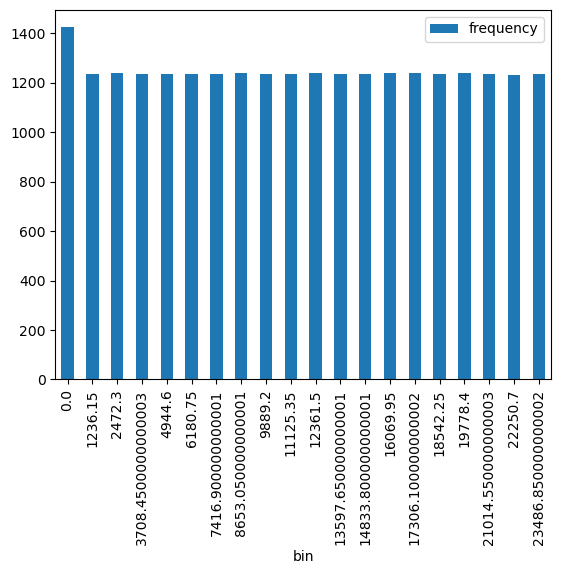

In [233]:
plot(df, "Popularity")

However, it is indeed that this column is just the ranking for the titles, which do not have much value in determining the actual differences between the popularity of two different anime titles. So it is better for us to drop this and come up with a different way to get the popularity.

In [ ]:
df = df.drop("Popularity")

#### Favorites, Scored By, Members (finished)

As we mentioned with the Popularity column, we shall find ways to represent an anime title's popularity. That is why we keep these 3 features and perform standardization.

In [ ]:
df = standard_score(df, "Favorites", "A1").drop("Favorites")
df = standard_score(df, "Scored_By", "B1").drop("Scored_By")
df = standard_score(df, "Members", "C1").drop("Members")

df = df.withColumnsRenamed({"A1":"Favorites", "B1":"Scored_By", "C1":"Members"})

This feature suggests the number of times an anime title is scored. As explained from the Popularity feature, this shall determine how popular a title is to be better on our ranking list.

#### Image URL (finished)

The feature has nothing to do with data processing, so the column is expected to be removed.

In [17]:
df = df.drop("Image URL")

#### Final results

In [18]:
df.show()

25/03/16 17:29:18 WARN TaskSetManager: Stage 561 contains a task of very large size (3156 KiB). The maximum recommended task size is 1000 KiB.
25/03/16 17:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1312.4 KiB


+--------+-----+--------+-----------+-------------+-------+----------+---------+---------+-------+------+---------+-------+-----+------+---------+-------+--------+------+----------+-----+-------+------+-----------+-------+-------+------+------+------------+-------------+-------------+---+---+-----+-------+-----+---+----------------+-------------+---------------+-----------------------+-------------+--------------+-----------------+------+---------------+------------+----------------+------------+----------------+-----+----+------+---------------------+---+------------------------+-------+-------------+-------+----------+------------------------+----+---------------+-------+-------+----------------+---------------+-------------------------+---------------------+------------------+-------+-------------------------+-----+---------+----------------+--------------------+-------+--------------------+---+---------+-------------+----------+------+-----+---------+-----------+----------+--------

In [19]:
#spark.stop()